# Семантика

## Завдання

Одне із змагань на SemEval-2015 було пов'язане з пошуком перефразувань та схожих за змістом твітів - [Paraphrase and Semantic Similarity in Twitter](http://alt.qcri.org/semeval2015/task1/). Ваше завдання цього тижня - побудувати модель, яка буде визначати перефразування та/або семантичну подібність краще, ніж бейзлайн у цьому змаганні.

Побудуйте одне із запропонованих рішень для цієї задачі (на вибір):

1. Побудуйте класифікатор на лінгвістичних ознаках (сутності, енграми слів чи символів, корені слів, редакторська відстань, синтаксична та семантична подібність тощо). **Обов'язкова умова** - використання семантичних ознак. Наприклад:
   - перетин слів та їх синонімів, гіпонімів, пов'язаних за темою слів тощо
   - середня близькість речень по онтології
   - редакторська відстань по AMR-графу
   - збіги по семантичних ролях

2. Побудуйте класифікатор на основі ваших улюблений векторних представлень слів. Поекспериментуйте з різними способами агрегації, відбору та зважування векторів. **Обов'язкова умова** - використання семантично збагачених векторів (як основне рішення чи для порівняння). Можна взяти готові вектори (наприклад, [ConceptNet Numberbatch](https://github.com/commonsense/conceptnet-numberbatch)) або самостійно виконати [ретрофіттинг](https://github.com/mfaruqui/retrofitting/blob/master/retrofit.py) на будь-яких стандартних векторах.

Більше натхнення щодо ознак та варіантів побудови рішення можна черпати зі [звіту про змагання](https://www.aclweb.org/anthology/S15-2001).

### Дані

Використайте дані та метрики з репозиторію змагання SemEval-2015 (архів опубліковано через Слек). Вся інформація щодо формату корпусу та метрик міститься в Readme.md.

Запустити метрику можна таким способом:
```
$ python scripts/pit2015_eval_single.py data/test.label systemoutputs/PIT2015_BASELINE_02_LG.output
838     BASELINE        02_LG           F: 0.589        Prec: 0.679     Rec: 0.520              P-corr: 0.511   F1: 0.601       Prec: 0.674     Rec: 0.543
```

**Важливо**: не заточуйтесь на test-дані. У корпусі є окремо виділений dev-сет, на якому можна порівнювати ваші рішення.

In [36]:
import pandas as pd
import gensim
from gensim.models import KeyedVectors

from scripts.pit2015_checkformat import CheckFileFormat
import scripts.pit2015_eval_single
from scripts.baseline_logisticregression import readInData, PREvaluation

from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

train_file = 'data/train.data'
test_file = 'data/test.data'

In [2]:
print('Using GPU:', torch.cuda.is_available())

Using GPU: True


### Train

In [3]:
columns = ['topic_id', 'topic_name', 'sent_1', 'sent_2', 'label', 'sent_1_tag', 'sent_2_tag']
df_train = pd.read_csv(train_file, sep='\t', names=columns)
df_train.loc[:,'label_bool'] = df_train['label'].map(lambda x: 1 if int(x[1])>=3 else 0 if int(x[1])<=1 else 'Invalid')
df_train = df_train[~(df_train['label_bool'] == 'Invalid')]
df_train.head()

,topic_id,topic_name,sent_1,sent_2,label,sent_1_tag,sent_2_tag,label_bool
0,4,1st QB,EJ Manuel the 1st QB to go in this draft,But my bro from the 757 EJ Manuel is the 1st Q...,"(5, 0)",EJ/B-person/NNP/B-NP/O Manuel/I-person/NNP/B-V...,But/O/CC/O/O my/O/PRP$/B-NP/O bro/O/NN/I-NP/O ...,1
1,4,1st QB,EJ Manuel the 1st QB to go in this draft,Can believe EJ Manuel went as the 1st QB in th...,"(5, 0)",EJ/B-person/NNP/B-NP/O Manuel/I-person/NNP/B-V...,Can/O/MD/B-VP/O believe/O/VB/I-VP/B-EVENT EJ/B...,1
2,4,1st QB,EJ Manuel the 1st QB to go in this draft,EJ MANUEL IS THE 1ST QB what,"(3, 2)",EJ/B-person/NNP/B-NP/O Manuel/I-person/NNP/B-V...,EJ/B-person/NNP/B-NP/O MANUEL/I-person/NNP/I-N...,1
4,4,1st QB,EJ Manuel the 1st QB to go in this draft,Manuel is the 1st QB to get drafted,"(4, 1)",EJ/B-person/NNP/B-NP/O Manuel/I-person/NNP/B-V...,Manuel/B-person/NNP/B-NP/O is/O/VBZ/B-VP/O the...,1
5,4,1st QB,EJ Manuel the 1st QB to go in this draft,My boy EJ Manuel being the 1st QB picked,"(5, 0)",EJ/B-person/NNP/B-NP/O Manuel/I-person/NNP/B-V...,My/O/PRP$/B-NP/O boy/O/NN/I-NP/O EJ/B-person/N...,1


### Test

In [4]:
columns = ['topic_id', 'topic_name', 'sent_1', 'sent_2', 'label', 'sent_1_tag', 'sent_2_tag']
df_test = pd.read_csv(test_file, sep='\t', names=columns)
df_test.loc[:,'label_bool'] = df_test['label'].map(lambda x: 1 if x>=4 else 0 if x<=2 else 'Invalid')
df_test = df_test[~(df_test['label_bool'] == 'Invalid')]
df_test.head(5)

,topic_id,topic_name,sent_1,sent_2,label,sent_1_tag,sent_2_tag,label_bool
1,51,8 Mile,All the home alones watching 8 mile,The last rap battle in 8 Mile nevr gets old ahah,2,All/O/DT/B-NP/O the/O/DT/I-NP/O home/O/NN/I-NP...,The/O/DT/B-NP/O last/O/JJ/I-NP/O rap/O/NN/I-NP...,0
2,51,8 Mile,All the home alones watching 8 mile,The rap battle at the end of 8 mile gets me so...,2,All/O/DT/B-NP/O the/O/DT/I-NP/O home/O/NN/I-NP...,The/O/DT/B-NP/O rap/O/NN/I-NP/O battle/O/NN/I-...,0
3,51,8 Mile,The Ending to 8 Mile is my fav part of the who...,Rabbit on 8 mile out of place but determined t...,1,The/O/DT/B-NP/O Ending/O/VBG/I-NP/B-EVENT to/O...,Rabbit/O/NNP/B-NP/O on/O/IN/B-PP/O 8/O/CD/B-NP...,0
4,51,8 Mile,The Ending to 8 Mile is my fav part of the who...,See 8 Mile is always on but it s the tv versio...,1,The/O/DT/B-NP/O Ending/O/VBG/I-NP/B-EVENT to/O...,See/O/VB/B-VP/O 8/O/CD/B-NP/O Mile/O/NNP/I-NP/...,0
5,51,8 Mile,The Ending to 8 Mile is my fav part of the who...,Those last 3 battles in 8 Mile are THE shit,4,The/O/DT/B-NP/O Ending/O/VBG/I-NP/B-EVENT to/O...,Those/O/DT/B-NP/O last/O/JJ/I-NP/O 3/O/CD/I-NP...,1


## WE

In [7]:
we_model = KeyedVectors.load_word2vec_format("we/numberbatch-en-17.06.txt.gz", binary=False)

we_model.most_similar(positive=['breakfast'], topn=10)

/olhasempienv/lib/python3.6/site-packages/gensim/models/keyedvectors.py:1366: RuntimeWarning: invalid value encountered in true_divide
  self.vectors_norm = (self.vectors / sqrt((self.vectors ** 2).sum(-1))[..., newaxis]).astype(REAL)
/olhasempienv/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('english_breakfast', 0.9580296277999878),
 ('breakfasts', 0.9542157649993896),
 ('jentacular', 0.9299718141555786),
 ('continental_breakfast', 0.9260205030441284),
 ("break_one's_fast", 0.916965663433075),
 ('brekkie', 0.909513533115387),
 ('breakfast_food', 0.9038169384002686),
 ('antejentacular', 0.8607983589172363),
 ('breakfaster', 0.8340396881103516),
 ('breakfasting', 0.8078814744949341)]

## Features

In [8]:
lemma = WordNetLemmatizer() 

def get_doc_emb(text):
    tokens = [lemma.lemmatize(i.lower()) for i in word_tokenize(text)
              if lemma.lemmatize(i.lower())]  # and not i.lower() in stop_words
    arr_tokens = np.array([we_model[i] for i in tokens if i in we_model.vocab])
    if arr_tokens.size != 0:
        max_ar = arr_tokens.max(axis=0)
        avg_ar =  arr_tokens.sum(axis=0) / arr_tokens.sum(axis=0).sum()
        arr_doc = np.concatenate((max_ar,avg_ar))
        return arr_doc.reshape(1, -1)
    else:
        return 'Empty'

def get_features(df):
    df_out = df.copy()
    df_out['doc_emb1'] = df_out['sent_1'].map(get_doc_emb)
    df_out['doc_emb2'] = df_out['sent_2'].map(get_doc_emb)
    df_out['emb_feature'] = df_out.apply(lambda x: np.concatenate((x['doc_emb1'], x['doc_emb2'])).reshape(1, -1)[0], axis=1)
    
    return df_out

In [45]:
df_train = get_features(df_train)
df_test = get_features(df_test)
df_test.head(5)

,topic_id,topic_name,sent_1,sent_2,label,sent_1_tag,sent_2_tag,label_bool,doc_emb1,doc_emb2,emb_feature
1,51,8 Mile,All the home alones watching 8 mile,The last rap battle in 8 Mile nevr gets old ahah,2,All/O/DT/B-NP/O the/O/DT/I-NP/O home/O/NN/I-NP...,The/O/DT/B-NP/O last/O/JJ/I-NP/O rap/O/NN/I-NP...,0,"[[0.168, 0.1674, 0.1012, 0.0851, -0.004, 0.060...","[[0.2522, 0.1907, 0.1012, 0.0457, 0.0382, 0.11...","[0.168, 0.1674, 0.1012, 0.0851, -0.004, 0.0602..."
2,51,8 Mile,All the home alones watching 8 mile,The rap battle at the end of 8 mile gets me so...,2,All/O/DT/B-NP/O the/O/DT/I-NP/O home/O/NN/I-NP...,The/O/DT/B-NP/O rap/O/NN/I-NP/O battle/O/NN/I-...,0,"[[0.168, 0.1674, 0.1012, 0.0851, -0.004, 0.060...","[[0.2522, 0.1907, 0.1012, 0.0769, 0.0621, 0.06...","[0.168, 0.1674, 0.1012, 0.0851, -0.004, 0.0602..."
3,51,8 Mile,The Ending to 8 Mile is my fav part of the who...,Rabbit on 8 mile out of place but determined t...,1,The/O/DT/B-NP/O Ending/O/VBG/I-NP/B-EVENT to/O...,Rabbit/O/NNP/B-NP/O on/O/IN/B-PP/O 8/O/CD/B-NP...,0,"[[0.1908, 0.1951, 0.1012, 0.0956, 0.0616, 0.10...","[[0.2602, 0.1951, 0.1951, 0.128, 0.0448, 0.128...","[0.1908, 0.1951, 0.1012, 0.0956, 0.0616, 0.104..."
4,51,8 Mile,The Ending to 8 Mile is my fav part of the who...,See 8 Mile is always on but it s the tv versio...,1,The/O/DT/B-NP/O Ending/O/VBG/I-NP/B-EVENT to/O...,See/O/VB/B-VP/O 8/O/CD/B-NP/O Mile/O/NNP/I-NP/...,0,"[[0.1908, 0.1951, 0.1012, 0.0956, 0.0616, 0.10...","[[0.2114, 0.1879, 0.1012, 0.0298, 0.0454, 0.12...","[0.1908, 0.1951, 0.1012, 0.0956, 0.0616, 0.104..."
5,51,8 Mile,The Ending to 8 Mile is my fav part of the who...,Those last 3 battles in 8 Mile are THE shit,4,The/O/DT/B-NP/O Ending/O/VBG/I-NP/B-EVENT to/O...,Those/O/DT/B-NP/O last/O/JJ/I-NP/O 3/O/CD/I-NP...,1,"[[0.1908, 0.1951, 0.1012, 0.0956, 0.0616, 0.10...","[[0.1278, 0.1674, 0.1085, 0.1166, 0.1859, 0.06...","[0.1908, 0.1951, 0.1012, 0.0956, 0.0616, 0.104..."


## NN

In [21]:
X_train = df_train['emb_feature'].tolist()
y_train = df_train['label_bool'].tolist()

X_test = df_test['emb_feature'].tolist()
y_test = df_test['label_bool'].tolist()

In [12]:
np.random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining Model
class FeedForwardNN(nn.Module):
    def __init__(self, require_bias=True):
        super(FeedForwardNN, self).__init__()
        self.linear1 = nn.Linear(in_features=1200, out_features=200)
        self.relu = nn.ReLU(inplace=False)
        self.linear2 = nn.Linear(in_features=200, out_features=2)
        
    def forward(self, inp_batch):
        out = self.linear1(inp_batch)
        out = self.relu(out)
        out = self.linear2(out)
        
        # Softmax layer
        tag_scores = F.log_softmax(out, dim=1)
        return tag_scores

In [35]:
print('Sentence pairs for training:', len(X_train))
print('Sentence pairs for testing:', len(X_test))

Sentence pairs for training: 11530
Sentence pairs for testing: 838


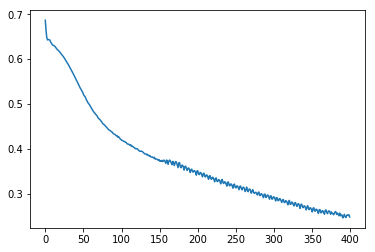

In [32]:
# INP_SIZE = len(X_train)

X_in = Variable(torch.FloatTensor(X_train), requires_grad=False) #?
y_in = Variable(torch.FloatTensor(y_train), requires_grad=False)

X_in = X_in.to(device)
y_in = y_in.to(device)

# Creating model and defining loss function and optimizer
model = FeedForwardNN()
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())
losses_visualize = []

model = model.to(device)
loss_fn = loss_fn.to(device)

model.train()

# Training the model
for epoch in range(400):
    optim.zero_grad()
    
    out = model(X_in)
    loss = loss_fn(out, y_in.long())
    losses_visualize.append(loss.item())
    
    loss.backward()
    optim.step()

plt.plot(losses_visualize)

In [44]:
X_te = Variable(torch.FloatTensor(X_test), requires_grad=False).to(device)
y_te = Variable(torch.FloatTensor(y_test), requires_grad=False).to(device)

def get_accuracy(model, X_te, y_labels):
    valid_loss = []
    model.eval()
    output = model(X_te)
    loss = loss_fn(output, y_te.long())
    valid_loss.append(loss.item())
    
    predicted = torch.argmax(output, 1)
    labels = y_labels.long()
    correct = (predicted == labels).sum().to(dtype=torch.float) 
    accuracy = (correct/ len(y_te))
    accuracy = accuracy.data.cpu().numpy().tolist()
    
    print('Validation loss:', valid_loss)
    print('Accuracy:', accuracy)
    
    pred_nums = predicted.cpu()
    label_nums = y_labels.cpu()
    
    print('\nConfusion matrix:')
    print(confusion_matrix(pred_nums, label_nums))
    
    print(classification_report(pred_nums, label_nums))

    return None

get_accuracy(model, X_te, y_te)

Validation loss: [0.7246323227882385]
Accuracy: 0.7625298500061035

Confusion matrix:
[[614 150]
 [ 49  25]]
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       764
           1       0.14      0.34      0.20        74

   micro avg       0.76      0.76      0.76       838
   macro avg       0.53      0.57      0.53       838
weighted avg       0.86      0.76      0.80       838



## Висновки
1. Зроблені document embeddings, які були побудовані на основі ConceptNet Numberbatch
2. Побудувала Feed Forward NN на document embeddings, яка є бінарним класифікатором чи є два речення перефразуванням (1) чи ні (0).